In [1]:
%matplotlib notebook
from scipy.ndimage import sobel, laplace
from scipy.stats import wilcoxon
import numpy as np
import pickle
import matplotlib.pyplot as plt


def rescale_values(image,max_val,min_val):
    '''
    image - numpy array
    max_val/min_val - float
    '''
    return (image-image.min())/(image.max()-image.min())*(max_val-min_val)+min_val

SEED=1234
np.random.seed(SEED)
# torch.manual_seed(SEED)

In [2]:
# Scale matrix to sum to 1
def sum_to_1(mat):
    return mat / np.sum(mat)

def rand_baseline(data: np.array):
    rands = np.random.uniform(low=-1.0, high=1.0, size=(data.shape))
    return sum_to_1(rands)

def x_baseline(data: np.array):
    rgb_weights = [0.2989, 0.5870, 0.1140]
    greyscale = np.dot(data[...,:3], rgb_weights)
    return sum_to_1(greyscale)

In [3]:
# # Confounder Data
# with open('confounder_train128.pkl', 'rb') as f:
#     confounder_train = pickle.load(f)
#     confounder_train = [[rescale_values(i[0],1,0).transpose(2,0,1),i[1]] for i in confounder_train]

# with open('confounder_val128.pkl', 'rb') as f:
#     confounder_val = pickle.load(f)
#     confounder_val = [[rescale_values(i[0],1,0).transpose(2,0,1),i[1]] for i in confounder_val]

# with open('confounder_test128.pkl', 'rb') as f:
#     confounder_test = pickle.load(f)
#     confounder_test = [[rescale_values(i[0],1,0).transpose(2,0,1),i[1]] for i in confounder_test]

    
# # Suppressor Data
# with open('suppressor_train128.pkl', 'rb') as f:
#     supressor_train = pickle.load(f)
#     supressor_train = [[rescale_values(i[0],1,0).transpose(2,0,1),i[1]] for i in supressor_train]

# with open('suppressor_validation128.pkl', 'rb') as f:
#     supressor_val = pickle.load(f)
#     supressor_val = [[rescale_values(i[0],1,0).transpose(2,0,1),i[1]] for i in supressor_val]

# with open('suppressor_test128.pkl', 'rb') as f:
#     supressor_test = pickle.load(f)
#     supressor_test = [[rescale_values(i[0],1,0).transpose(2,0,1),i[1]] for i in supressor_test]


# # No Watermark Data
# with open('no_mark_train128.pkl', 'rb') as f:
#     no_mark_train = pickle.load(f)
#     no_mark_train = [[rescale_values(i[0],1,0).transpose(2,0,1),i[1]] for i in no_mark_train]

# with open('no_mark_validation128.pkl', 'rb') as f:
#     no_mark_val = pickle.load(f)
#     no_mark_val = [[rescale_values(i[0],1,0).transpose(2,0,1),i[1]] for i in no_mark_val]

# with open('no_mark_test128.pkl', 'rb') as f:
#     no_mark_test = pickle.load(f)
#     no_mark_test = [[rescale_values(i[0],1,0).transpose(2,0,1),i[1]] for i in no_mark_test]

In [4]:
with open('mark_all128.pkl', 'rb') as f:
    watermark_dataset = pickle.load(f)
    watermark_dataset = [[rescale_values(i[0],1,0).transpose(2,0,1),i[1]] for i in watermark_dataset]

with open('no_mark_test128.pkl', 'rb') as f:
    no_watermark_dataset = pickle.load(f)
    no_watermark_dataset = [[rescale_values(i[0],1,0).transpose(2,0,1),i[1]] for i in no_watermark_dataset]

In [5]:
train_energy=[]
methods = ['deconv', 'int_grads', 'shap', 'lrp', 'lrp_ab'] # lime just nan values
# methods = ['deconv', 'int_grads', 'shap', 'lrp']
n_test = 3000

energies = {}

for method in methods:
    energies[method] = {}
    comb_water_conf = []
    comb_water_sup = []
    comb_water_no = []
    
    comb_no_water_conf = []
    comb_no_water_sup = []
    comb_no_water_no = []
    
    for model_ind in range(10):
        file = open(f'energy_water_conf_comb_pred_{model_ind}.pickle', 'rb')
        energy_water_conf = pickle.load(file)

        file = open(f'energy_water_sup_comb_pred_{model_ind}.pickle', 'rb')
        energy_water_sup = pickle.load(file)

        file = open(f'energy_water_no_comb_pred_{model_ind}.pickle', 'rb')
        energy_water_no = pickle.load(file)

        file = open(f'energy_no_water_conf_comb_pred_{model_ind}.pickle', 'rb')
        energy_no_water_conf = pickle.load(file)

        file = open(f'energy_no_water_sup_comb_pred_{model_ind}.pickle', 'rb')
        energy_no_water_sup = pickle.load(file)

        file = open(f'energy_no_water_no_comb_pred_{model_ind}.pickle', 'rb')
        energy_no_water_no = pickle.load(file)
        
        comb_water_conf.extend(energy_water_conf[method][:n_test])
        comb_water_sup.extend(energy_water_sup[method][:n_test])
        comb_water_no.extend(energy_water_no[method][:n_test])

        comb_no_water_conf.extend(energy_no_water_conf[method][:n_test])
        comb_no_water_sup.extend(energy_no_water_sup[method][:n_test])
        comb_no_water_no.extend(energy_no_water_no[method][:n_test])
        
    energies[method]['conf'] = [comb_no_water_conf, comb_water_conf]
    energies[method]['sup'] = [comb_no_water_sup, comb_water_sup]
    energies[method]['no'] = [comb_no_water_no, comb_water_no]
    
    train_energy.append([[comb_no_water_conf, comb_water_conf],
                [comb_no_water_sup, comb_water_sup],
                [comb_no_water_no, comb_water_no]])
    
np.array(train_energy).shape

(5, 3, 2, 30000)

## Hypothesis 1
- if the XAI methods work as expected as confounder detectors, the relative energy should differ betwen W and NO-W test images only for the confounder case, but not for the other two.
- Using a [paired Wilcoxon signed-rank test](https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test) to test significance
- Evaluate differences between E(W_i) and E(NoW_i) for all three models for each given XAI method

In [6]:
wilcoxon(x=energies['lrp']['conf'][1], y=energies['lrp']['conf'][0], alternative='greater')

WilcoxonResult(statistic=450009014.0, pvalue=0.0)

In [7]:
wilcoxon(energies['lrp']['sup'][1], energies['lrp']['sup'][0], alternative='greater')

WilcoxonResult(statistic=449848990.0, pvalue=0.0)

In [8]:
wilcoxon(energies['lrp']['no'][1], energies['lrp']['no'][0], alternative='greater')

WilcoxonResult(statistic=450004121.0, pvalue=0.0)

In [9]:
np.array(train_energy[0][0][1]) - np.array(train_energy[0][0][0])

array([ 0.25734605, -0.13538006, -0.19057381, ...,  0.07337203,
        0.06062911,  0.29702779])

<IPython.core.display.Javascript object>


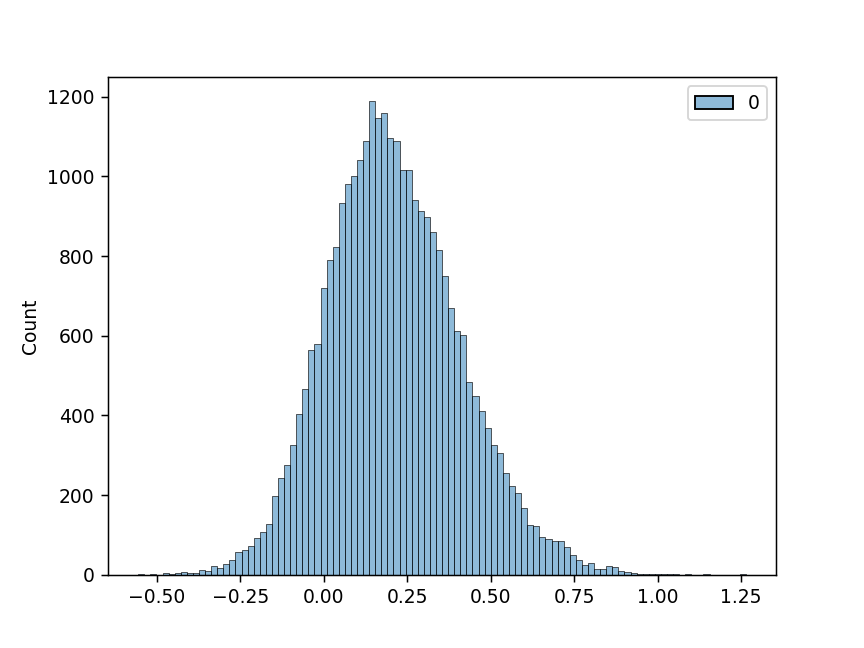

<AxesSubplot:ylabel='Count'>

In [10]:
import seaborn as sns
fig, axs = plt.subplots(1)
sns.histplot(ax=axs,data=[np.array(train_energy[0][0][1]) - np.array(train_energy[0][0][0])],bins=100)

In [11]:
for method, results in energies.items():
    for model, result in results.items():
        res = wilcoxon(result[1], result[0], alternative='greater')
        print(method, model, res.statistic, res.pvalue)

deconv conf 423212177.0 0.0
deconv sup 300223185.0 0.0
deconv no 441069453.0 0.0
int_grads conf 450014454.0 0.0
int_grads sup 450000539.0 0.0
int_grads no 450013298.0 0.0
shap conf 450004643.0 0.0
shap sup 449913454.0 0.0
shap no 450006574.0 0.0
lrp conf 450009014.0 0.0
lrp sup 449848990.0 0.0
lrp no 450004121.0 0.0
lrp_ab conf 449622403.0 0.0
lrp_ab sup 446913920.0 0.0
lrp_ab no 447420096.0 0.0


In [12]:
# Effect size as rank-biserial correlation
# aka (test statistic / total rank sum)
for method, results in energies.items():
    for model, result in results.items():
        res = wilcoxon(result[1], result[0], alternative='greater')
        rank_sum = sum(np.where(np.array(result[1]) ==  np.array(result[1]))[0])
        print(method, model, res.statistic/rank_sum, res.pvalue)

deconv conf 0.9405028545395958 0.0
deconv sup 0.6671848728290943 0.0
deconv no 0.98018701290043 0.0
int_grads conf 1.0000654555151838 0.0
int_grads sup 1.0000345322621864 0.0
int_grads no 1.0000628865406624 0.0
shap conf 1.0000436525661967 0.0
shap sup 0.9998410035890085 0.0
shap no 1.0000479438203496 0.0
lrp conf 1.0000533662233186 0.0
lrp sup 0.9996977454804049 0.0
lrp no 1.0000424925275286 0.0
lrp_ab conf 0.9991942020289565 0.0
lrp_ab sup 0.9931751502827872 0.0
lrp_ab no 0.9943000233341112 0.0


In [13]:
import pickle as pkl

with open('energy_laplace.pickle', 'rb') as f:
    lapl = pkl.load(f)
    
with open('energy_sobel.pickle', 'rb') as f:
    sob= pkl.load(f)

In [14]:
lapl_no, lapl_wm = lapl
sob_no, sob_wm = sob

## Hypothesis 2
if the XAI methods work as expected as confounder detectors, then the relative energy on W test images should be higher for confounded training data then for the other two. If this is the case - how big is the effect?
- Meaning, how much more watermark energy is attributed by models trained on confounded data compared to models trained on unconfounded data.
- Calculate E(Wˆtr=Conf_i) - E(Wˆtr=Supp_i) and E(Wˆtr=Conf_i) - E(Wˆtr=NoW_i) for all XAI methods

In [15]:
for method, results in energies.items():
    #  E(Wˆtr=Conf_i) - E(Wˆtr=Supp_i) 
    res_sup = wilcoxon(results['conf'][1], results['sup'][1], alternative='greater')
    
    #  E(Wˆtr=Conf_i) - E(Wˆtr=NoW_i) 
    res_no = wilcoxon(results['conf'][1], results['no'][1], alternative='greater')
    
    rank_sum = sum(np.where(np.array(results['conf'][1]) ==  np.array(results['conf'][1]))[0])
    
    print(method, 'CONF - SUPP', res_sup.statistic/rank_sum, res_sup.pvalue)
    print(method, 'CONF - NO', res_no.statistic/rank_sum, res_no.pvalue)

deconv CONF - SUPP 0.9435834283365001 0.0
deconv CONF - NO 0.09632353967354468 1.0
int_grads CONF - SUPP 0.8844980454904052 0.0
int_grads CONF - NO 0.014807140238007934 1.0
shap CONF - SUPP 0.8700898185495072 0.0
shap CONF - NO 0.025158805293509785 1.0
lrp CONF - SUPP 0.880248557174128 0.0
lrp CONF - NO 0.16623282998322167 1.0
lrp_ab CONF - SUPP 0.9384658310832583 0.0
lrp_ab CONF - NO 0.684961812060402 0.0


## Coloured MNIST

In [16]:
method = 'shap'

conf_conf = [[],[],[]]
conf_sup = [[],[],[]]
conf_no = [[],[],[]]

sup_conf = [[],[],[]]
sup_sup = [[],[],[]]
sup_no = [[],[],[]]

no_conf = [[],[],[]]
no_sup = [[],[],[]]
no_no = [[],[],[]]

for model_ind in range(5):
    file = open(f'energies_mnist_{model_ind}.pickle', 'rb')
    energies = pickle.load(file)
    
    for i in range(3):
        conf_conf[i].extend(energies['conf']['conf'][i][method])
        conf_sup[i].extend(energies['conf']['sup'][i][method])
        conf_no[i].extend(energies['conf']['no_col'][i][method])
        
        sup_conf[i].extend(energies['sup']['conf'][i][method])
        sup_sup[i].extend(energies['sup']['sup'][i][method])
        sup_no[i].extend(energies['sup']['no_col'][i][method])

        no_conf[i].extend(energies['no_col']['conf'][i][method])
        no_sup[i].extend(energies['no_col']['sup'][i][method])
        no_no[i].extend(energies['no_col']['no_col'][i][method])
        
        
combined_energies = {
    'conf': { # conf model on conf/sup/no data
        'conf': conf_conf,
        'sup': conf_sup, 
        'no_col': conf_no},
            
    'sup': { # sup model on conf/sup/no data
        'conf': sup_conf,
        'sup': sup_sup, 
        'no_col': sup_no},

    'no_col': { # no_col model on conf/sup/no data
        'conf': no_conf,
        'sup': no_sup, 
        'no_col': no_no},
}

In [ ]:
wilcoxon(x=energies['lrp']['conf'][1], y=energies['lrp']['conf'][0], alternative='greater')